# Demo: Raster fundamentals, Rasterio, Band Math with Arrays
UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

## Introduction
See reading assignment [05_Raster1_GDAL_rasterio_LS8_prep](./05_Raster1_GDAL_rasterio_LS8_prep.md)

## What is a raster?

## Raster data sources
* Satellite imagery
* Gridded model output
* Interpolated vector data

## Raster fundamentals
Interactive discussion during demo

### Dimensions (width [columns] and height [rows] in pixels)
### CRS (coordinate system)
### Extent (bounds)
### Resolution (pixel size)
### Data type (bit depth)
### Number of bands
### NoData values

## GDAL (Geospatial Data Abstraction Library) and Rasterio
GDAL is a powerful and mature library for reading, writing and warping raster datasets, written in C++ with bindings to other languages. There are a variety of geospatial libraries available on the python package index, and almost all of them depend on GDAL. One such python library developed and supported by Mapbox, rasterio, builds on top of GDAL’s many features, but provides a more pythonic interface and supports many of the features and formats that GDAL supports. Both GDAL and rasterio are constantly being updated and improved.

## Raster formats
* GeoTiff is most common
* GDAL is the foundation - drivers for hundreds of formats

## CRS and Projections
* Most often UTM
* PROJ is the foundation (as with GeoPandas)

## Raster transformations

### Sensor to raster image
* Simple example of a 2D CCD/CMOS detector in a simple camera (e.g., Planet Dove)
* Snapshot of the Earth
* Sensor model allows you to relate each pixel in the image to a geographic location on the ground
* Existing DEM to produce an orthorectified image in some projected coordinate system
* That's where we start

### Raster image (lines, samples) to projected coordinates
* Need a way to relate from pixel coordinates (2D rectangular image on your screen) to real-world coordinates (projected)
    * Pixel coordinates: image width, height in units of pixels, starting at (0,0)
    * Real-world coordiantes: projected coordinate system (e.g., UTM 10N), units of meters
* Origin is usually upper left corner of upper left pixel
    * Careful about this - you will definitely run into this problem at some point
    * Often your grid may be shifted by a half a pixel in x and y
* Negative y cell size - what's up with that?

### GDAL/ESRI affine

### rasterio affine
* Multiply affine by raster indices to get projected coordinates
* Rasterio dataset `xy` and `index` methods

## Basic raster structure
* Dataset
* Bands
    * Often just 1 band, sometimes multiple bands (new axis)
* Read band to get underlying 2D array data
    * Handling missing data (nodata) - masked arrays vs. np.nan

### Overviews

## 3D array to create composites from multispectral bands
* Can dstack 2D arrays

## Misc
* Be careful with large rasters, esp float - don't load into memory
* Read in a window or every nth pixel when prototyping. Only read in full res when ready.
* Try to avoid creating many copies of arrays

## GDAL command line utilities

* Learn these: https://gdal.org/programs/index.html
    * gdalinfo
    * gdal_translate
    * gdalwarp
    * gdaladdo
* Items to discuss
    * Use standard creation options (co)
        * TILED=YES
        * COMPRESS=LZW
        * BIGTIFF=IF_SAFER
    * Resampling algorithms
        * Default is nearest
        * Often bilinear or bicubic is a better choice for reprojecting, upsampling, downsampling

https://medium.com/planet-stories/a-gentle-introduction-to-gdal-part-4-working-with-satellite-data-d3835b5e2971

# Demo

https://automating-gis-processes.github.io/site/notebooks/Raster/reading-raster.html

In [ ]:
pwd

'/home/jovyan/jupyterbook/book/modules/05_Raster1_GDAL_rasterio_LS8'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
import rasterio.plot
from osgeo import gdal

#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#matplotlib widget
%matplotlib inline

In [ ]:
#Create local directory to store images
imgdir = 'LS8_sample'
#Summer 2018
img_id1 = 'LC08_L1TP_046027_20180818_20180829_01_T1'
#Winter 2018
img_id2 = 'LC08_L1TP_046027_20181224_20190129_01_T1'

img = img_id1

## Specify filenames for specific bands used for later examples

In [ ]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number

#Red
r_fn = os.path.join(imgdir, img+'_B4.TIF')
#Green
g_fn = os.path.join(imgdir, img+'_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, img+'_B2.TIF')
#Near-Infrared
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
#Shortwave-Infrared
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
#Panchromatic
p_fn = os.path.join(imgdir, img+'_B8.TIF')

In [ ]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number
tir_fn = os.path.join(imgdir, img+'_B10.TIF')
print(tir_fn)

LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF


In [ ]:
#Using Collection 2 L2 products (calibrated surface reflectance, temperature)
#img = 'LC08_L2SP_046027_20180818_20200831_02_T1'
#tir_fn = os.path.join(imgdir, img+'_ST_B10.TIF')

In [ ]:
!gdalinfo $tir_fn

Driver: GTiff/GeoTIFF
Files: LS8_sample/LC08_L1TP_046027_20180818_20180829_01_T1_B10.TIF
Size is 7781, 7881
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",

# Rasterio basics
* We'll stick with rasterio for most of our Python raster analysis 
* https://rasterio.readthedocs.io/en/stable/quickstart.html

## Use a Python `with` construct to cleanly open, inspect, and close the file directly from the url
* The Python `with` construct may be new, or maybe you used it during Lab02 when opening a text file for reading/writing.
* It is "used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams."
    * Enables more elegant file opening/closing and handling errors (like missing files)
* Let's use the `with rio.open()` approach to print out the rasterio dataset profile, without actually reading the underlying image data
    * We will temporarily store the rasterio dataset with variable name `src` (short for "source")

In [ ]:
with rio.open(tir_fn) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


## Can also open dataset with rasterio for persistence and interactive access
* This is likely a better option as you're learning, as you can access the opened dataset and arrays you've already read in other cells
* Remember to close the rasterio dataset when no longer needed!

In [ ]:
src = rio.open(tir_fn)

In [ ]:
type(src)

rasterio.io.DatasetReader

In [ ]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7781, 'height': 7881, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [ ]:
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 7781,
 'height': 7881,
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'transform': Affine(30.0, 0.0, 473385.0,
        0.0, -30.0, 5373315.0)}

In [ ]:
src.crs

CRS.from_epsg(32610)

### Plot using rasterio `show()` function
* Note axes tick labels

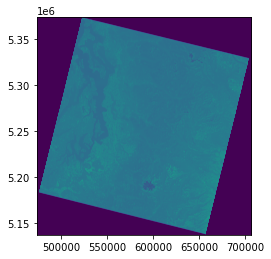

In [ ]:
rio.plot.show(src);

### Read the array

In [ ]:
#src.read?

In [ ]:
#Note memory usage before and after reading
%time
a = src.read(1)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [ ]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

### Plot using Matplotlib `imshow`
* Note axes tick labels

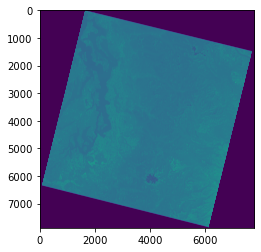

In [ ]:
f,ax = plt.subplots()
ax.imshow(a);

## Inspect the array

In [ ]:
a.shape

(7881, 7781)

In [ ]:
a.size

61322061

In [ ]:
a.dtype

dtype('uint16')

In [ ]:
a.min()

0

In [ ]:
a.max()

65535

In [ ]:
2**16

65536

In [ ]:
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [ ]:
a.ravel()

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

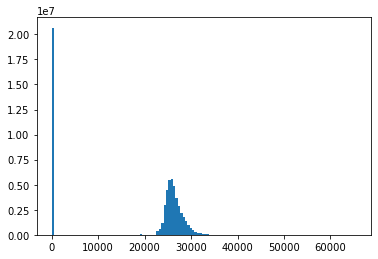

In [ ]:
f, ax = plt.subplots()
plt.hist(a.ravel(), bins=128);

## Image bit depth
Number of possible intensity values

In [ ]:
#Landsat-8 OLI is 12-bit sensor
2**12

4096

In [ ]:
2**16

65536

## Use a masked array to handle nodata

In [ ]:
src.nodata

In [ ]:
src.nodatavals

(None,)

In [ ]:
#Normally, rasterio handles on the fly
#Unfortunately nodata is not set properly in the Collection 1 GeoTiff on Google Cloud
a = src.read(1, masked=True)

In [ ]:
a

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],
  mask=False,
  fill_value=999999,
  dtype=uint16)

In [ ]:
np.ma.masked_equal?

Signature: np.ma.masked_equal(x, value, copy=True)
Docstring:
Mask an array where equal to a given value.

This function is a shortcut to ``masked_where``, with
`condition` = (x == value).  For floating point arrays,
consider using ``masked_values(x, value)``.

See Also
--------
masked_where : Mask where a condition is met.
masked_values : Mask using floating point equality.

Examples
--------
>>> import numpy.ma as ma
>>> a = np.arange(4)
>>> a
array([0, 1, 2, 3])
>>> ma.masked_equal(a, 2)
masked_array(data=[0, 1, --, 3],
             mask=[False, False,  True, False],
       fill_value=2)
File:      /srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/ma/core.py
Type:      function


In [ ]:
np.ma.masked_equal(a, 0)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [ ]:
a = np.ma.masked_equal(a, 0)

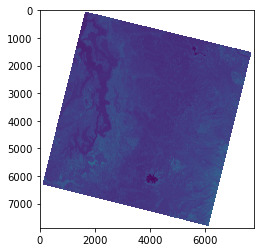

In [ ]:
f, ax = plt.subplots()
plt.imshow(a);

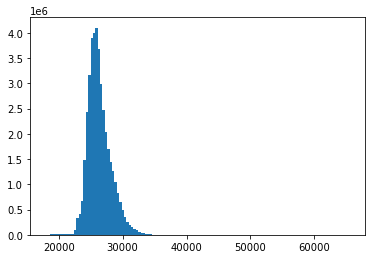

In [ ]:
f, ax = plt.subplots()
plt.hist(a.ravel(), bins=128);

### Bounds and extent

In [ ]:
#This is rasterio bounds object - note labels like dictionary keys and values
src.bounds

BoundingBox(left=473385.0, bottom=5136885.0, right=706815.0, top=5373315.0)

In [ ]:
#This is matplotlib extent
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[473385.0, 706815.0, 5136885.0, 5373315.0]


In [ ]:
#rasterio convenience function
full_extent = rio.plot.plotting_extent(src)
print(full_extent)

(473385.0, 706815.0, 5136885.0, 5373315.0)


### Plot the image with `imshow`, but now pass in this `extent` as an argument
* Note how the axes coordinates change
    * These should now be meters in the UTM 10N coordinate system of the projected image!

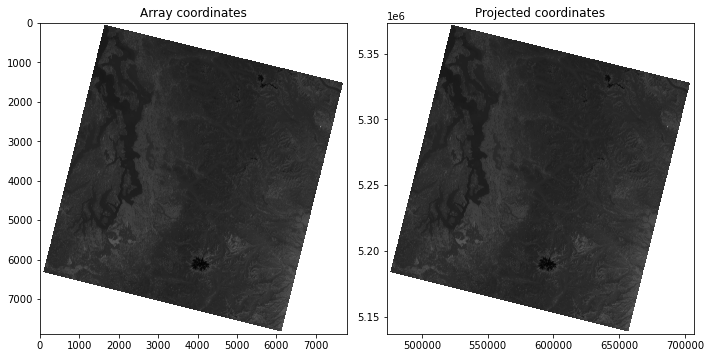

In [ ]:
f, axa = plt.subplots(1,2, figsize=(10,6))
axa[0].imshow(a, cmap='gray') #vmin=0, vmax=1
axa[0].set_title("Array coordinates")
axa[1].imshow(a, extent=full_extent, cmap='gray') #vmin=0, vmax=1
axa[1].set_title("Projected coordinates")
plt.tight_layout()

## Raster transform
* How does rasterio know the bounds of the array?
* Inspect the dataset `transform` attribute
* You may have encountered an ESRI "world file" or GDAL geotransform before. This is the same idea, but Rasterio's model uses traditional affine transform.
* Review this: https://rasterio.readthedocs.io/en/stable/topics/georeferencing.html?highlight=affine#coordinate-transformation

In [ ]:
src.transform

Affine(30.0, 0.0, 473385.0,
       0.0, -30.0, 5373315.0)

In [ ]:
#These are (x,y) for corners in pixel space
#A bit confusing due to (row,col) of shape, which is (y,x)

#Upper left
ul = (0, 0)
#Lower right
lr = (a.shape[1], a.shape[0])

In [ ]:
#Transform upper left corner
ul_proj = src.transform * ul
ul_proj

(473385.0, 5373315.0)

In [ ]:
#Transform lower right corner
lr_proj = src.transform * lr
lr_proj

(706815.0, 5136885.0)

In [ ]:
wh_km = np.abs(np.array(ul_proj) - np.array(lr_proj))/1000
wh_km
print('Total width: %0.2f km\nTotal height: %0.2f km' % (wh_km[0], wh_km[1]))

Total width: 233.43 km
Total height: 236.43 km


## Raster and array sampling
* Use helper functions `xy` and `sample`

In [ ]:
#Array coordinates
c = (3512, 3512)

In [ ]:
a[3000,3000]

27559

In [ ]:
#Get value at coordinates using array indexing
a[c[0], c[1]]

25468

In [ ]:
#src.xy?

In [ ]:
#Note use of argument expansion here (*c) so we don't have to pass individual c[0] and c[1] values
x,y = src.xy(*c)
print(x,y)

578760.0 5267940.0


In [ ]:
#src.sample?

In [ ]:
src.sample(x, y)

<generator object sample_gen at 0x7f44e0518820>

In [ ]:
#Doesn't work
#list(src.sample(x, y))

In [ ]:
src.sample([(x, y),])

<generator object sample_gen at 0x7f44e0491820>

In [ ]:
#Pass in a list, and evaluate the generator
list(src.sample([(x, y),]))

[array([25468], dtype=uint16)]

## Windowing and indexing

In [ ]:
chunk = a[3000:4024,3000:4024]
chunk

masked_array(
  data=[[27559, 27638, 27596, ..., 24997, 25006, 25020],
        [27099, 27126, 27077, ..., 24994, 24996, 25005],
        [26799, 26776, 26735, ..., 24984, 24983, 24987],
        ...,
        [28986, 29076, 29005, ..., 24825, 24819, 24818],
        [29032, 29157, 29110, ..., 24823, 24811, 24806],
        [28960, 29155, 29129, ..., 24823, 24809, 24799]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16)

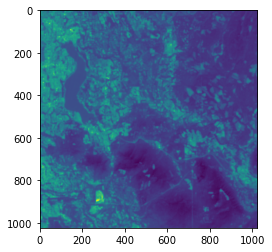

In [ ]:
f, ax = plt.subplots()
plt.imshow(chunk)

### Store a reduced resolution view (1 pixel for every 100 original pixels)

In [ ]:
asub = a[::10, ::10]
asub

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0,
  dtype=uint16)

In [ ]:
asub.shape

(789, 779)

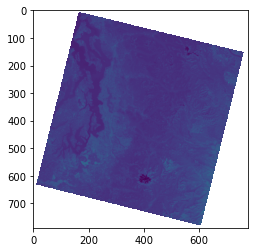

In [ ]:
#Every 10th pixel - great strategy for quick visualization during development/exploration
f, ax = plt.subplots()
plt.imshow(asub);

## Raster math

In [ ]:
#%matplotlib widget

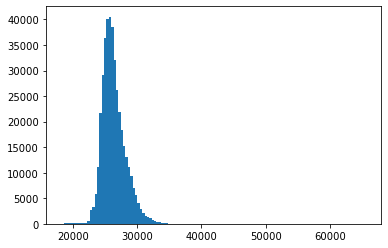

In [ ]:
#Remember to use compressed for historgrams with 2D masked arrays
f, ax = plt.subplots()
plt.hist(asub.compressed(), bins=128);

In [ ]:
asub < 24000

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0)

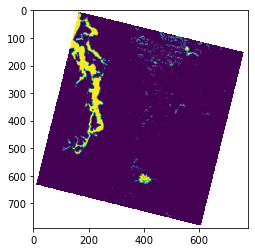

In [ ]:
f, ax = plt.subplots()
plt.imshow(asub < 24000);

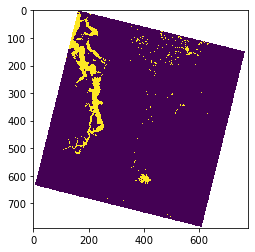

In [ ]:
plt.imshow(asub < 24000, interpolation='none');

## Calculating area

In [ ]:
(asub < 24000).sum()

19903

In [ ]:
src.res

(30.0, 30.0)

In [ ]:
#Delete array from memory
asub = None
a = None
#Close the rasterio dataset
src.close()

## GDAL Python API basics
* I'm including this for reference
    * It's not that complicated, even though rasterio is the more popular option for Python these days (partly because of much better documentation)
* https://gdal.org/user/raster_data_model.html
* https://github.com/OSGeo/gdal/tree/master/gdal/swig/python/samples
* https://pcjericks.github.io/py-gdalogr-cookbook/index.html

In [ ]:
#Open the green band GeoTiff as GDAL Dataset object
ds = gdal.Open(tir_fn)

In [ ]:
#Get the raster band
gdal_b = ds.GetRasterBand(1)
#Read into array
a = gdal_b.ReadAsArray()

In [ ]:
#Inspect the array
a

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

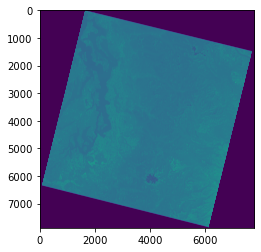

In [ ]:
#View the array
f, ax = plt.subplots()
ax.imshow(a);

In [ ]:
#Set array to None (frees up RAM) and close GDAL dataset
a = None
ds = None